In [12]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, ActivityRegularization
from tensorflow.keras.regularizers import l2

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

In [2]:

# Download the train, validation and test dataset which were created with the dataset preprocess files

# file_id_audio = [
#     '1NNxYN2DbuDF0tvzbZTQ_EPEJ5uIPZPai', # https://drive.google.com/file/d/1NNxYN2DbuDF0tvzbZTQ_EPEJ5uIPZPai/view?usp=sharing
#     '1-CMJZY4allQBba5gl5s0Y-RT9Qdma_Mj', # https://drive.google.com/file/d/1-CMJZY4allQBba5gl5s0Y-RT9Qdma_Mj/view?usp=sharing
#     '1--LAbXygf83JJuY-Do3tG_6cVxSErHr5', # https://drive.google.com/file/d/1--LAbXygf83JJuY-Do3tG_6cVxSErHr5/view?usp=sharing
# ]


# for i, id in enumerate(file_id_audio):
#   # Check if the file already exists
#   if (not os.path.exists('val_dataset.tfrecord')) or (not os.path.exists('train_dataset.tfrecord')) or (not os.path.exists('test_dataset.tfrecord')):
#     !wget --content-disposition 'https://drive.google.com/uc?export=download&id={id}&confirm=t'




In [3]:
# Another way to get the dataset from the Google Drive and the working enviroment is Google Colab 

# from google.colab import drive
# drive.mount('/content/drive')

# import shutil

# drive_file_path = '/content/drive/MyDrive/test_dataset.tfrecord'
# colab_file_path = '/content/test_dataset.tfrecord'

# shutil.copy(drive_file_path, colab_file_path)

# drive_file_path = '/content/drive/MyDrive/val_dataset.tfrecord'
# colab_file_path = '/content/val_dataset.tfrecord'

# shutil.copy(drive_file_path, colab_file_path)


# drive_file_path = '/content/drive/MyDrive/train_dataset.tfrecord'
# colab_file_path = '/content/train_dataset.tfrecord'

# shutil.copy(drive_file_path, colab_file_path)

In [4]:

# Function to parse TFRecord entries, declaring the metadatas of the TFRecord files
def _parse_function(proto):
    keys_to_features = {
        'data': tf.io.FixedLenFeature([128 * 313 * 3], tf.float32),
        'labels': tf.io.FixedLenFeature([], tf.int64),
    }
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)
    parsed_features['data'] = tf.reshape(parsed_features['data'], (128, 313, 3))
    return parsed_features['data'], parsed_features['labels']





In [5]:
# Load and parse TFRecord datasets for testing, validation,and training
# These dataset are pipelined so they are not loaded to the memory.

test_dataset = tf.data.TFRecordDataset('test_dataset.tfrecord').map(_parse_function)
val_dataset = tf.data.TFRecordDataset('val_dataset.tfrecord').map(_parse_function)
train_dataset = tf.data.TFRecordDataset('train_dataset.tfrecord').map(_parse_function)

In [6]:
# Create a ResNet model with a pre-trained ResNet50 base

resnet_model = Sequential()
pretrained_model= tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(128,313,3),
    pooling='avg',classes=264,
    weights='imagenet')

# Freeze pre-trained ResNet50 layers
for layer in pretrained_model.layers:
        layer.trainable=False


resnet_model.add(pretrained_model)
resnet_model.add(Flatten())

resnet_model.add(BatchNormalization())

# Add Dense layers with dropout and L2 regularization
resnet_model.add(Dense(256, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.5))


resnet_model.add(Dense(256, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.5))


resnet_model.add(Dense(264, activation='softmax'))

In [7]:
# Compile the model
resnet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
resnet_model.summary()


In [8]:
# Prefetch datasets for better performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Shuffle training dataset
train_dataset = train_dataset.shuffle(300)



In [ ]:

# Define early stopping and checkpoint callbacks
patience = 20
early_stopping=EarlyStopping(patience=patience, verbose=2)
checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=2)

In [9]:
# Train the model
num_epochs = 20
batch_size = 256

history = resnet_model.fit(
    train_dataset.batch(batch_size),
    epochs=num_epochs,
    validation_data=val_dataset.batch(batch_size),
    callbacks=[checkpointer, early_stopping]
)

Epoch 1/20
60/60 [==============================] - 101s 1s/step - loss: 6.4441 - accuracy: 0.0156 - val_loss: 5.9536 - val_accuracy: 0.0028
Epoch 2/20
60/60 [==============================] - 74s 1s/step - loss: 5.7693 - accuracy: 0.0423 - val_loss: 5.8336 - val_accuracy: 0.0028
Epoch 3/20
60/60 [==============================] - 73s 1s/step - loss: 5.4797 - accuracy: 0.0615 - val_loss: 5.7075 - val_accuracy: 0.0271
Epoch 4/20
60/60 [==============================] - 73s 1s/step - loss: 5.2609 - accuracy: 0.0744 - val_loss: 5.6080 - val_accuracy: 0.0346
Epoch 5/20
60/60 [==============================] - 73s 1s/step - loss: 5.0917 - accuracy: 0.0871 - val_loss: 5.5165 - val_accuracy: 0.0476
Epoch 6/20
60/60 [==============================] - 72s 1s/step - loss: 4.9290 - accuracy: 0.1042 - val_loss: 5.3927 - val_accuracy: 0.0600
Epoch 7/20
60/60 [==============================] - 72s 1s/step - loss: 4.8125 - accuracy: 0.1131 - val_loss: 5.2725 - val_accuracy: 0.0659
Epoch 8/20
60/60 [=

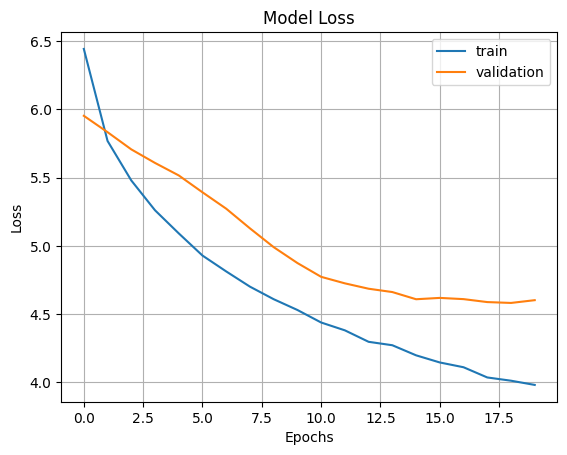

In [13]:
# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [14]:
# Get the accuracy on the test dataset

evaluation_result = resnet_model.evaluate(test_dataset.batch(batch_size))

loss_value = evaluation_result[0]

accuracy_value = evaluation_result[1]


14/14 [==============================] - 20s 1s/step - loss: 4.5671 - accuracy: 0.1515


In [15]:
print(f'the test accuracy is {accuracy_value}')

the test accuracy is 0.15152370929718018
